# Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import nibabel as nib
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
from joblib import Parallel, delayed
from adjustText import adjust_text
from matplotlib.patches import Ellipse
import re
import os

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

weights_dir = '/Users/baileyng/MIND_models/models_plsregression/PLS_weights'

# PLS Analysis Function

In [4]:
# inner parallelized
def pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10):
    preprocessor = ColumnTransformer(transformers=[
        # scale continuous features
        ('num', StandardScaler(), continuous_vars),
        # one-hot encode the assessment centre (drop one level to avoid collinearity)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
    ])

    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_ncomps = []
    coefs_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV
        pipe = make_pipeline(
            preprocessor,
            PLSRegression()
        )

        param_grid = {
            'plsregression__n_components': list(range(1, 11))
        }

        inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        grid = GridSearchCV(
            pipe, 
            param_grid, 
            cv=inner_cv, 
            scoring='neg_mean_squared_error',  # or 'r2'
            n_jobs=-1
        )
        
        grid.fit(X_train, y_train)
        best_n = grid.best_params_['plsregression__n_components']
        best_ncomps.append(best_n)
        
        y_pred = grid.predict(X_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- extract loadings and compute VIP ---
        pls = grid.best_estimator_.named_steps['plsregression']
        coefs_list.append(pls.coef_.ravel())
        
        T = pls.x_scores_
        W = pls.x_weights_
        Q = pls.y_loadings_
        p, h = W.shape

        print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
            f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'n_components (mean ± std): '
        f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
    print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
    print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')

    # Get feature names after preprocessing
    # First, fit the preprocessor to get the transformed feature names
    preprocessor_fitted = preprocessor.fit(X)

    # Get feature names for each transformer
    num_features = continuous_vars
    cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

    # Combine all feature names in the correct order
    all_feature_names = num_features + cat_features


    # Final refit on all data
    mean_ncomps = int(np.round(np.mean(best_ncomps)))

    final_pipe = make_pipeline(
        preprocessor,
        PLSRegression(
            n_components=mean_ncomps
        )
    ).fit(X, y)

    pls = final_pipe.named_steps['plsregression']
    ct  = final_pipe.named_steps['columntransformer']

    W = pls.x_weights_

    os.makedirs(weights_dir, exist_ok=True)

    #Create a DataFrame to store the weights
    weights_df = pd.DataFrame(W, 
                              index=all_feature_names, 
                              columns=[f'Component_{i+1}' for i in range(W.shape[1])])

    weights_filename = f'PLS_weights_{data_name}_{target_name}.csv'
    weights_filepath = os.path.join(weights_dir, weights_filename)
    weights_df.to_csv(weights_filepath)

    print(f"PLS weights saved to: {weights_filepath}")
    print(f"Final model parameters: n_components={mean_ncomps}")


# # demographic only (inner parallelized)
# def pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10):
#     preprocessor = ColumnTransformer(transformers=[
#         # scale continuous features
#         ('num', StandardScaler(), continuous_vars),
#         # one-hot encode the assessment centre (drop one level to avoid collinearity)
#         ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
#     ])

#     # Cross-validation set-up
#     outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     outer_mae, outer_rmse, outer_r2 = [], [], []
#     best_ncomps = []
#     coefs_list = []

#     for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#         # Inner CV
#         pipe = make_pipeline(
#             preprocessor,
#             PLSRegression()
#         )

#         param_grid = {
#             'plsregression__n_components': list(range(1, 4))
#         }

#         inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
#         grid = GridSearchCV(
#             pipe, 
#             param_grid, 
#             cv=inner_cv, 
#             scoring='neg_mean_squared_error',  # or 'r2'
#             n_jobs=-1
#         )
        
#         grid.fit(X_train, y_train)
#         best_n = grid.best_params_['plsregression__n_components']
#         best_ncomps.append(best_n)
        
#         y_pred = grid.predict(X_test)

#         # --- metrics ---
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         r2 = r2_score(y_test, y_pred)

#         outer_mae.append(mae)
#         outer_rmse.append(rmse)
#         outer_r2.append(r2)

#         # --- extract loadings and compute VIP ---
#         pls = grid.best_estimator_.named_steps['plsregression']
#         coefs_list.append(pls.coef_.ravel())
        
#         T = pls.x_scores_
#         W = pls.x_weights_
#         Q = pls.y_loadings_
#         p, h = W.shape

#         print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
#             f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

#     # Aggregate results
#     print('\n=== 10-fold CV summary ===')
#     print(f'n_components (mean ± std): '
#         f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
#     print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
#     print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
#     print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')


In [6]:
# inner parallelized (demographic only)
def pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10):
    preprocessor = ColumnTransformer(transformers=[
        # scale continuous features
        ('num', StandardScaler(), continuous_vars),
        # one-hot encode the assessment centre (drop one level to avoid collinearity)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
    ])

    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_ncomps = []
    coefs_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV
        pipe = make_pipeline(
            preprocessor,
            PLSRegression()
        )

        param_grid = {
            'plsregression__n_components': list(range(1, 4))
        }

        inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        grid = GridSearchCV(
            pipe, 
            param_grid, 
            cv=inner_cv, 
            scoring='neg_mean_squared_error',  # or 'r2'
            n_jobs=-1
        )
        
        grid.fit(X_train, y_train)
        best_n = grid.best_params_['plsregression__n_components']
        best_ncomps.append(best_n)
        
        y_pred = grid.predict(X_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- extract loadings and compute VIP ---
        pls = grid.best_estimator_.named_steps['plsregression']
        coefs_list.append(pls.coef_.ravel())
        
        T = pls.x_scores_
        W = pls.x_weights_
        Q = pls.y_loadings_
        p, h = W.shape

        print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
            f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'n_components (mean ± std): '
        f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
    print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
    print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')

    # Get feature names after preprocessing
    # First, fit the preprocessor to get the transformed feature names
    preprocessor_fitted = preprocessor.fit(X)

    # Get feature names for each transformer
    num_features = continuous_vars
    cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

    # Combine all feature names in the correct order
    all_feature_names = num_features + cat_features


    # Final refit on all data
    mean_ncomps = int(np.round(np.mean(best_ncomps)))

    final_pipe = make_pipeline(
        preprocessor,
        PLSRegression(
            n_components=mean_ncomps
        )
    ).fit(X, y)

    pls = final_pipe.named_steps['plsregression']
    ct  = final_pipe.named_steps['columntransformer']

    W = pls.x_weights_

    os.makedirs(weights_dir, exist_ok=True)

    #Create a DataFrame to store the weights
    weights_df = pd.DataFrame(W, 
                              index=all_feature_names, 
                              columns=[f'Component_{i+1}' for i in range(W.shape[1])])

    weights_filename = f'PLS_weights_{data_name}_{target_name}.csv'
    weights_filepath = os.path.join(weights_dir, weights_filename)
    weights_df.to_csv(weights_filepath)

    print(f"PLS weights saved to: {weights_filepath}")
    print(f"Final model parameters: n_components={mean_ncomps}")


# # demographic only (inner parallelized)
# def pls_analysis(X, y, continuous_vars, categorical_vars, n_splits=10):
#     preprocessor = ColumnTransformer(transformers=[
#         # scale continuous features
#         ('num', StandardScaler(), continuous_vars),
#         # one-hot encode the assessment centre (drop one level to avoid collinearity)
#         ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
#     ])

#     # Cross-validation set-up
#     outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     outer_mae, outer_rmse, outer_r2 = [], [], []
#     best_ncomps = []
#     coefs_list = []

#     for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#         # Inner CV
#         pipe = make_pipeline(
#             preprocessor,
#             PLSRegression()
#         )

#         param_grid = {
#             'plsregression__n_components': list(range(1, 4))
#         }

#         inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
#         grid = GridSearchCV(
#             pipe, 
#             param_grid, 
#             cv=inner_cv, 
#             scoring='neg_mean_squared_error',  # or 'r2'
#             n_jobs=-1
#         )
        
#         grid.fit(X_train, y_train)
#         best_n = grid.best_params_['plsregression__n_components']
#         best_ncomps.append(best_n)
        
#         y_pred = grid.predict(X_test)

#         # --- metrics ---
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         r2 = r2_score(y_test, y_pred)

#         outer_mae.append(mae)
#         outer_rmse.append(rmse)
#         outer_r2.append(r2)

#         # --- extract loadings and compute VIP ---
#         pls = grid.best_estimator_.named_steps['plsregression']
#         coefs_list.append(pls.coef_.ravel())
        
#         T = pls.x_scores_
#         W = pls.x_weights_
#         Q = pls.y_loadings_
#         p, h = W.shape

#         print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
#             f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
        

#     # Aggregate results
#     print('\n=== 10-fold CV summary ===')
#     print(f'n_components (mean ± std): '
#         f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
#     print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
#     print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
#     print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')


# GF

In [7]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_GF_no_outliers.csv', index_col=0)
target_name = 'GF'

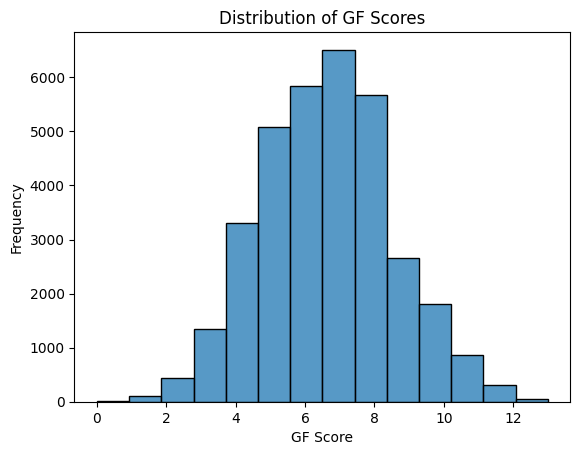

In [8]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'], bins=14)
plt.title('Distribution of GF Scores')
plt.xlabel('GF Score')
plt.ylabel('Frequency')
plt.show()

In [9]:
print(len(df))
print(df.shape)

33977
(33977, 2628)


## GF vs. MIND (avg)

In [8]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 71)
(33977,)


In [9]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [10]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=04 • MAE=1.621 • RMSE=2.020 • R²=0.029
Fold 02 • n_comp=04 • MAE=1.636 • RMSE=2.034 • R²=0.031
Fold 03 • n_comp=03 • MAE=1.643 • RMSE=2.043 • R²=0.039
Fold 04 • n_comp=04 • MAE=1.653 • RMSE=2.059 • R²=0.032
Fold 05 • n_comp=03 • MAE=1.605 • RMSE=2.004 • R²=0.030
Fold 06 • n_comp=03 • MAE=1.585 • RMSE=1.976 • R²=0.043
Fold 07 • n_comp=03 • MAE=1.617 • RMSE=2.018 • R²=0.032
Fold 08 • n_comp=03 • MAE=1.657 • RMSE=2.052 • R²=0.022
Fold 09 • n_comp=03 • MAE=1.607 • RMSE=2.002 • R²=0.036
Fold 10 • n_comp=04 • MAE=1.629 • RMSE=2.034 • R²=0.035

=== 10-fold CV summary ===
n_components (mean ± std): 3.4 ± 0.5
MAE :  1.625 ± 0.022
RMSE:  2.024 ± 0.024
R²  :  0.033 ± 0.005
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_avg_GF.csv
Final model parameters: n_components=3


## GF vs. CT

In [14]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 65)
(33977,)


In [15]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [16]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=06 • MAE=1.632 • RMSE=2.032 • R²=0.018
Fold 02 • n_comp=05 • MAE=1.644 • RMSE=2.042 • R²=0.024
Fold 03 • n_comp=09 • MAE=1.651 • RMSE=2.057 • R²=0.026
Fold 04 • n_comp=05 • MAE=1.662 • RMSE=2.070 • R²=0.021
Fold 05 • n_comp=05 • MAE=1.604 • RMSE=2.002 • R²=0.032
Fold 06 • n_comp=05 • MAE=1.589 • RMSE=1.985 • R²=0.035
Fold 07 • n_comp=06 • MAE=1.631 • RMSE=2.035 • R²=0.015
Fold 08 • n_comp=08 • MAE=1.652 • RMSE=2.046 • R²=0.028
Fold 09 • n_comp=09 • MAE=1.623 • RMSE=2.016 • R²=0.022
Fold 10 • n_comp=06 • MAE=1.637 • RMSE=2.043 • R²=0.026

=== 10-fold CV summary ===
n_components (mean ± std): 6.4 ± 1.6
MAE :  1.632 ± 0.021
RMSE:  2.033 ± 0.024
R²  :  0.025 ± 0.006
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_CT_GF.csv
Final model parameters: n_components=6


## GF vs. FC

In [ ]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 214)
(33977,)


In [ ]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [ ]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=05 • MAE=1.581 • RMSE=1.985 • R²=0.063
Fold 02 • n_comp=05 • MAE=1.599 • RMSE=1.990 • R²=0.073
Fold 03 • n_comp=05 • MAE=1.615 • RMSE=2.020 • R²=0.060
Fold 04 • n_comp=05 • MAE=1.615 • RMSE=2.018 • R²=0.070
Fold 05 • n_comp=05 • MAE=1.573 • RMSE=1.964 • R²=0.068
Fold 06 • n_comp=05 • MAE=1.545 • RMSE=1.929 • R²=0.088
Fold 07 • n_comp=05 • MAE=1.598 • RMSE=1.995 • R²=0.053
Fold 08 • n_comp=05 • MAE=1.604 • RMSE=2.000 • R²=0.071
Fold 09 • n_comp=05 • MAE=1.572 • RMSE=1.965 • R²=0.070
Fold 10 • n_comp=05 • MAE=1.590 • RMSE=1.987 • R²=0.079

=== 10-fold CV summary ===
n_components (mean ± std): 5.0 ± 0.0
MAE :  1.589 ± 0.021
RMSE:  1.985 ± 0.026
R²  :  0.070 ± 0.009
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_FC_GF.csv


## GF vs. Demographic Data

In [10]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 3)
(33977,)


In [12]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [13]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=02 • MAE=1.634 • RMSE=2.040 • R²=0.010
Fold 02 • n_comp=02 • MAE=1.654 • RMSE=2.051 • R²=0.015
Fold 03 • n_comp=02 • MAE=1.666 • RMSE=2.072 • R²=0.012
Fold 04 • n_comp=02 • MAE=1.670 • RMSE=2.076 • R²=0.015
Fold 05 • n_comp=02 • MAE=1.614 • RMSE=2.015 • R²=0.019
Fold 06 • n_comp=02 • MAE=1.601 • RMSE=1.998 • R²=0.022
Fold 07 • n_comp=03 • MAE=1.642 • RMSE=2.044 • R²=0.006
Fold 08 • n_comp=02 • MAE=1.670 • RMSE=2.062 • R²=0.012
Fold 09 • n_comp=02 • MAE=1.631 • RMSE=2.023 • R²=0.015
Fold 10 • n_comp=02 • MAE=1.652 • RMSE=2.054 • R²=0.016

=== 10-fold CV summary ===
n_components (mean ± std): 2.1 ± 0.3
MAE :  1.643 ± 0.022
RMSE:  2.044 ± 0.024
R²  :  0.014 ± 0.004
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_demo_GF.csv
Final model parameters: n_components=2


# PAL

In [14]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_PAL_no_outliers.csv', index_col=0)
target_name = 'PAL'

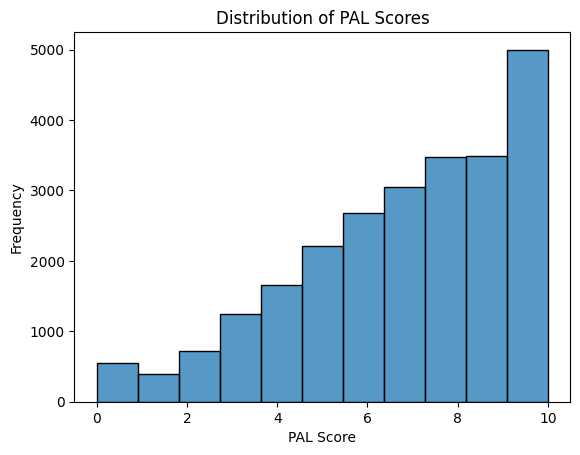

In [15]:
# Histogram of PAL Scores
sns.histplot(df['20197-2.0'], bins=11)
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
print(len(df))
print(df.shape)

24492
(24492, 2628)


### PAL vs. MIND (avg)

In [26]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 71)
(24492,)


In [27]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [28]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=05 • MAE=2.076 • RMSE=2.539 • R²=0.064
Fold 02 • n_comp=05 • MAE=2.104 • RMSE=2.551 • R²=0.046
Fold 03 • n_comp=05 • MAE=2.098 • RMSE=2.584 • R²=0.062
Fold 04 • n_comp=04 • MAE=2.071 • RMSE=2.533 • R²=0.059
Fold 05 • n_comp=05 • MAE=2.040 • RMSE=2.476 • R²=0.053
Fold 06 • n_comp=04 • MAE=2.105 • RMSE=2.559 • R²=0.081
Fold 07 • n_comp=05 • MAE=2.089 • RMSE=2.538 • R²=0.062
Fold 08 • n_comp=05 • MAE=2.068 • RMSE=2.536 • R²=0.065
Fold 09 • n_comp=05 • MAE=2.082 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.070 • RMSE=2.542 • R²=0.047

=== 10-fold CV summary ===
n_components (mean ± std): 4.8 ± 0.4
MAE :  2.080 ± 0.019
RMSE:  2.541 ± 0.026
R²  :  0.061 ± 0.009
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_avg_PAL.csv


### PAL vs. CT

In [29]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 65)
(24492,)


In [30]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [31]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=05 • MAE=2.081 • RMSE=2.537 • R²=0.066
Fold 02 • n_comp=05 • MAE=2.106 • RMSE=2.556 • R²=0.043
Fold 03 • n_comp=05 • MAE=2.096 • RMSE=2.581 • R²=0.064
Fold 04 • n_comp=05 • MAE=2.065 • RMSE=2.532 • R²=0.060
Fold 05 • n_comp=05 • MAE=2.041 • RMSE=2.475 • R²=0.055
Fold 06 • n_comp=06 • MAE=2.107 • RMSE=2.564 • R²=0.077
Fold 07 • n_comp=05 • MAE=2.087 • RMSE=2.537 • R²=0.063
Fold 08 • n_comp=05 • MAE=2.073 • RMSE=2.540 • R²=0.061
Fold 09 • n_comp=05 • MAE=2.084 • RMSE=2.554 • R²=0.066
Fold 10 • n_comp=05 • MAE=2.076 • RMSE=2.542 • R²=0.048

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.3
MAE :  2.082 ± 0.019
RMSE:  2.542 ± 0.027
R²  :  0.060 ± 0.009
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_CT_PAL.csv


### PAL vs. FC

In [32]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 214)
(24492,)


In [33]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [34]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=09 • MAE=2.035 • RMSE=2.503 • R²=0.091
Fold 02 • n_comp=10 • MAE=2.039 • RMSE=2.497 • R²=0.087
Fold 03 • n_comp=09 • MAE=2.055 • RMSE=2.543 • R²=0.091
Fold 04 • n_comp=09 • MAE=2.035 • RMSE=2.496 • R²=0.087
Fold 05 • n_comp=10 • MAE=1.994 • RMSE=2.423 • R²=0.093
Fold 06 • n_comp=09 • MAE=2.053 • RMSE=2.523 • R²=0.106
Fold 07 • n_comp=10 • MAE=2.031 • RMSE=2.487 • R²=0.099
Fold 08 • n_comp=09 • MAE=2.032 • RMSE=2.500 • R²=0.091
Fold 09 • n_comp=09 • MAE=2.037 • RMSE=2.515 • R²=0.094
Fold 10 • n_comp=10 • MAE=2.016 • RMSE=2.484 • R²=0.091

=== 10-fold CV summary ===
n_components (mean ± std): 9.4 ± 0.5
MAE :  2.033 ± 0.017
RMSE:  2.497 ± 0.030
R²  :  0.093 ± 0.006
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_FC_PAL.csv


## PAL vs. Demographic Data

In [17]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 3)
(24492,)


In [18]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [19]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=03 • MAE=2.088 • RMSE=2.546 • R²=0.059
Fold 02 • n_comp=03 • MAE=2.105 • RMSE=2.556 • R²=0.043
Fold 03 • n_comp=03 • MAE=2.101 • RMSE=2.587 • R²=0.059
Fold 04 • n_comp=03 • MAE=2.074 • RMSE=2.537 • R²=0.056
Fold 05 • n_comp=03 • MAE=2.044 • RMSE=2.473 • R²=0.056
Fold 06 • n_comp=03 • MAE=2.114 • RMSE=2.571 • R²=0.071
Fold 07 • n_comp=03 • MAE=2.092 • RMSE=2.544 • R²=0.058
Fold 08 • n_comp=03 • MAE=2.069 • RMSE=2.536 • R²=0.065
Fold 09 • n_comp=03 • MAE=2.086 • RMSE=2.557 • R²=0.064
Fold 10 • n_comp=03 • MAE=2.075 • RMSE=2.543 • R²=0.047

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  2.085 ± 0.019
RMSE:  2.545 ± 0.029
R²  :  0.058 ± 0.008
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_demo_PAL.csv
Final model parameters: n_components=3


# DSST

In [20]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_DSST_no_outliers.csv', index_col=0)
target_name = 'DSST'

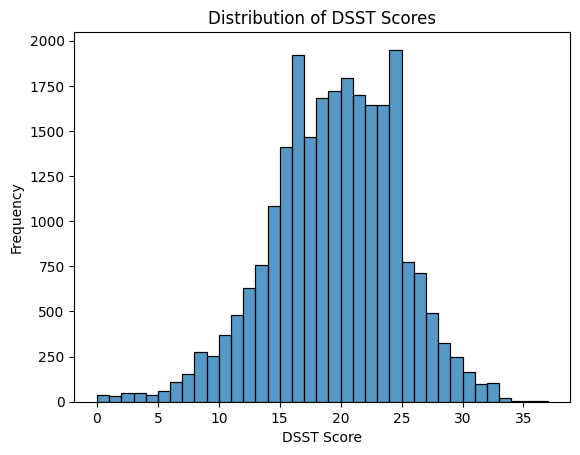

In [21]:
# Histogram of DSST Scores
sns.histplot(df['23324-2.0'], bins=37)
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

In [22]:
print(len(df))
print(df.shape)

24275
(24275, 2628)


### DSST vs. MIND (avg)

In [41]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 71)
(24275,)


In [42]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [43]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=05 • MAE=3.703 • RMSE=4.712 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.804 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=05 • MAE=3.725 • RMSE=4.712 • R²=0.200
Fold 04 • n_comp=06 • MAE=3.665 • RMSE=4.619 • R²=0.161
Fold 05 • n_comp=06 • MAE=3.782 • RMSE=4.816 • R²=0.181
Fold 06 • n_comp=06 • MAE=3.701 • RMSE=4.738 • R²=0.195
Fold 07 • n_comp=06 • MAE=3.738 • RMSE=4.754 • R²=0.188
Fold 08 • n_comp=06 • MAE=3.713 • RMSE=4.738 • R²=0.184
Fold 09 • n_comp=06 • MAE=3.640 • RMSE=4.636 • R²=0.189
Fold 10 • n_comp=06 • MAE=3.650 • RMSE=4.597 • R²=0.203

=== 10-fold CV summary ===
n_components (mean ± std): 5.8 ± 0.4
MAE :  3.712 ± 0.050
RMSE:  4.717 ± 0.077
R²  :  0.190 ± 0.013
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_avg_DSST.csv


### DSST vs. CT

In [44]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 65)
(24275,)


In [45]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [46]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=06 • MAE=3.709 • RMSE=4.711 • R²=0.193
Fold 02 • n_comp=06 • MAE=3.811 • RMSE=4.845 • R²=0.207
Fold 03 • n_comp=06 • MAE=3.715 • RMSE=4.713 • R²=0.199
Fold 04 • n_comp=06 • MAE=3.659 • RMSE=4.612 • R²=0.163
Fold 05 • n_comp=06 • MAE=3.789 • RMSE=4.831 • R²=0.176
Fold 06 • n_comp=06 • MAE=3.700 • RMSE=4.728 • R²=0.198
Fold 07 • n_comp=06 • MAE=3.743 • RMSE=4.774 • R²=0.181
Fold 08 • n_comp=06 • MAE=3.722 • RMSE=4.751 • R²=0.179
Fold 09 • n_comp=06 • MAE=3.643 • RMSE=4.639 • R²=0.188
Fold 10 • n_comp=06 • MAE=3.652 • RMSE=4.610 • R²=0.198

=== 10-fold CV summary ===
n_components (mean ± std): 6.0 ± 0.0
MAE :  3.714 ± 0.053
RMSE:  4.721 ± 0.079
R²  :  0.188 ± 0.013
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_CT_DSST.csv


### DSST vs. FC

In [47]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 214)
(24275,)


In [48]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [49]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=09 • MAE=3.647 • RMSE=4.658 • R²=0.211
Fold 02 • n_comp=09 • MAE=3.773 • RMSE=4.814 • R²=0.217
Fold 03 • n_comp=09 • MAE=3.699 • RMSE=4.674 • R²=0.213
Fold 04 • n_comp=09 • MAE=3.648 • RMSE=4.611 • R²=0.164
Fold 05 • n_comp=09 • MAE=3.779 • RMSE=4.796 • R²=0.188
Fold 06 • n_comp=09 • MAE=3.669 • RMSE=4.691 • R²=0.211
Fold 07 • n_comp=09 • MAE=3.714 • RMSE=4.719 • R²=0.200
Fold 08 • n_comp=10 • MAE=3.684 • RMSE=4.727 • R²=0.187
Fold 09 • n_comp=10 • MAE=3.633 • RMSE=4.616 • R²=0.196
Fold 10 • n_comp=09 • MAE=3.617 • RMSE=4.565 • R²=0.214

=== 10-fold CV summary ===
n_components (mean ± std): 9.2 ± 0.4
MAE :  3.686 ± 0.053
RMSE:  4.687 ± 0.076
R²  :  0.200 ± 0.016
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_FC_DSST.csv


## DSST vs. Demographic Data

In [23]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 3)
(24275,)


In [24]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [25]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=03 • MAE=3.725 • RMSE=4.734 • R²=0.185
Fold 02 • n_comp=03 • MAE=3.810 • RMSE=4.852 • R²=0.205
Fold 03 • n_comp=03 • MAE=3.722 • RMSE=4.722 • R²=0.196
Fold 04 • n_comp=03 • MAE=3.674 • RMSE=4.631 • R²=0.156
Fold 05 • n_comp=03 • MAE=3.798 • RMSE=4.849 • R²=0.170
Fold 06 • n_comp=03 • MAE=3.716 • RMSE=4.749 • R²=0.191
Fold 07 • n_comp=03 • MAE=3.761 • RMSE=4.786 • R²=0.177
Fold 08 • n_comp=03 • MAE=3.731 • RMSE=4.774 • R²=0.171
Fold 09 • n_comp=03 • MAE=3.657 • RMSE=4.660 • R²=0.181
Fold 10 • n_comp=03 • MAE=3.666 • RMSE=4.622 • R²=0.194

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  3.726 ± 0.050
RMSE:  4.738 ± 0.078
R²  :  0.183 ± 0.014
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_demo_DSST.csv
Final model parameters: n_components=3


# TMT

In [26]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_TMT_no_outliers.csv', index_col=0)
target_name = 'TMT'

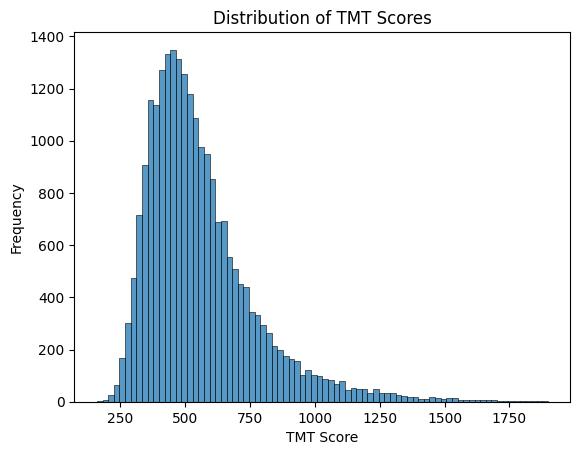

In [27]:
# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'], bins=80)
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

In [28]:
print(len(df))
print(df.shape)

23362
(23362, 2628)


### TMT vs. MIND (avg)

In [56]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 71)
(23362,)


In [57]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [58]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=06 • MAE=152.318 • RMSE=204.732 • R²=0.098
Fold 02 • n_comp=06 • MAE=142.837 • RMSE=190.780 • R²=0.137
Fold 03 • n_comp=06 • MAE=144.857 • RMSE=197.484 • R²=0.121
Fold 04 • n_comp=06 • MAE=142.657 • RMSE=197.176 • R²=0.136
Fold 05 • n_comp=06 • MAE=140.738 • RMSE=190.721 • R²=0.133
Fold 06 • n_comp=06 • MAE=144.204 • RMSE=201.155 • R²=0.125
Fold 07 • n_comp=06 • MAE=144.319 • RMSE=195.567 • R²=0.133
Fold 08 • n_comp=07 • MAE=146.228 • RMSE=203.530 • R²=0.146
Fold 09 • n_comp=05 • MAE=147.680 • RMSE=203.748 • R²=0.124
Fold 10 • n_comp=05 • MAE=147.192 • RMSE=202.258 • R²=0.153

=== 10-fold CV summary ===
n_components (mean ± std): 5.9 ± 0.5
MAE :  145.303 ± 3.092
RMSE:  198.715 ± 4.938
R²  :  0.131 ± 0.014
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_avg_TMT.csv


### TMT vs. CT

In [59]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 65)
(23362,)


In [60]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [61]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=06 • MAE=152.069 • RMSE=204.187 • R²=0.103
Fold 02 • n_comp=05 • MAE=142.597 • RMSE=190.942 • R²=0.136
Fold 03 • n_comp=05 • MAE=145.190 • RMSE=197.621 • R²=0.119
Fold 04 • n_comp=05 • MAE=141.833 • RMSE=197.567 • R²=0.132
Fold 05 • n_comp=05 • MAE=141.372 • RMSE=191.402 • R²=0.127
Fold 06 • n_comp=05 • MAE=145.111 • RMSE=201.368 • R²=0.123
Fold 07 • n_comp=05 • MAE=145.290 • RMSE=195.711 • R²=0.132
Fold 08 • n_comp=05 • MAE=147.614 • RMSE=204.960 • R²=0.134
Fold 09 • n_comp=05 • MAE=147.860 • RMSE=203.735 • R²=0.125
Fold 10 • n_comp=05 • MAE=148.069 • RMSE=202.969 • R²=0.147

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.3
MAE :  145.700 ± 3.140
RMSE:  199.046 ± 4.936
R²  :  0.128 ± 0.011
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_CT_TMT.csv


### TMT vs. FC

In [62]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 214)
(23362,)


In [63]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [64]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=10 • MAE=150.771 • RMSE=201.648 • R²=0.125
Fold 02 • n_comp=09 • MAE=142.185 • RMSE=189.841 • R²=0.146
Fold 03 • n_comp=09 • MAE=143.033 • RMSE=195.107 • R²=0.142
Fold 04 • n_comp=10 • MAE=139.365 • RMSE=193.056 • R²=0.171
Fold 05 • n_comp=09 • MAE=140.170 • RMSE=189.078 • R²=0.148
Fold 06 • n_comp=09 • MAE=143.335 • RMSE=198.413 • R²=0.149
Fold 07 • n_comp=09 • MAE=141.680 • RMSE=192.026 • R²=0.165
Fold 08 • n_comp=09 • MAE=144.788 • RMSE=200.041 • R²=0.175
Fold 09 • n_comp=08 • MAE=143.833 • RMSE=199.569 • R²=0.160
Fold 10 • n_comp=08 • MAE=146.041 • RMSE=200.870 • R²=0.164

=== 10-fold CV summary ===
n_components (mean ± std): 9.0 ± 0.6
MAE :  143.520 ± 3.075
RMSE:  195.965 ± 4.490
R²  :  0.154 ± 0.015
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_FC_TMT.csv


## TMT vs. Demographic Data

In [29]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 3)
(23362,)


In [30]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [31]:
pls_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • n_comp=03 • MAE=152.282 • RMSE=204.259 • R²=0.102
Fold 02 • n_comp=03 • MAE=142.748 • RMSE=191.249 • R²=0.133
Fold 03 • n_comp=03 • MAE=145.659 • RMSE=198.146 • R²=0.115
Fold 04 • n_comp=03 • MAE=142.949 • RMSE=198.163 • R²=0.127
Fold 05 • n_comp=03 • MAE=141.653 • RMSE=191.782 • R²=0.123
Fold 06 • n_comp=03 • MAE=145.550 • RMSE=202.484 • R²=0.114
Fold 07 • n_comp=03 • MAE=145.553 • RMSE=196.516 • R²=0.125
Fold 08 • n_comp=03 • MAE=147.787 • RMSE=205.066 • R²=0.133
Fold 09 • n_comp=03 • MAE=147.829 • RMSE=203.702 • R²=0.125
Fold 10 • n_comp=03 • MAE=149.105 • RMSE=204.382 • R²=0.135

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  146.111 ± 3.079
RMSE:  199.575 ± 4.941
R²  :  0.123 ± 0.010
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_demo_TMT.csv
Final model parameters: n_components=3
